# In this assignment we learn about numerical stability of the covariance matrix, fitting $\chi^2$ distributions, to correct for the Hartlap factor.

Rashaad Reid (20852657)

February 15, 2024

## For this assignment no external packages are required. You just need a running conda environment, where numpy and matplotlib are installed.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv, eigvals
from scipy.special import gamma, factorial
from scipy.optimize import curve_fit
from scipy.stats import chi2 as chi2_scp

In [2]:
# this cell is for formatting plots, and can be commented out if it causes problems
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

## Preparation: load in the data we need for this assignment.

In [3]:
model=np.load('data_4_assignment1/reference_model.npy') # This will be our reference model
cov=np.load('data_4_assignment1/covariance.npy') # This is the analytical covariance matrix, which we assume is the true covariance of the data

## Task 1: Create two sets of 10000 noisy Gaussian data vectors each using the provided reference model and true covariance matrix. 

In [4]:
# create 2 sets of noisy data vectors based on the model
noisy_data_set1 = np.random.multivariate_normal(model,cov,10000)
noisy_data_set2 = np.random.multivariate_normal(model,cov,10000)

We'll check that the noisy data vectors scatter around the truth by first plotting a single noisy data vector on the same plot as the model.

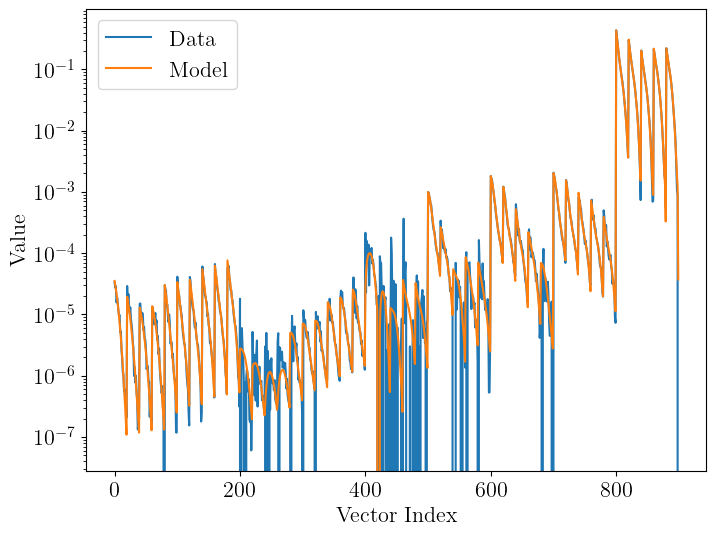

In [5]:
# plot the first noisy data vector and the model
plt.figure(figsize=(8,6),dpi=100)
plt.plot(noisy_data_set1[0],label='Data')
plt.plot(model,label='Model')
plt.yscale('log') # log scale to see structure
plt.xlabel('Vector Index')
plt.ylabel('Value')
plt.legend()
plt.show()

We see above that the noisy data vector oscillates around the model, largely overlapping with it. The occasional drops in the data vector on the log-scale plot are due to some of the points being negative. This is not a problem, as the data is still scattered around the truth.

We'll further verify that the noisy data scatters around the truth by plotting the residuals of the data with respect to the model.

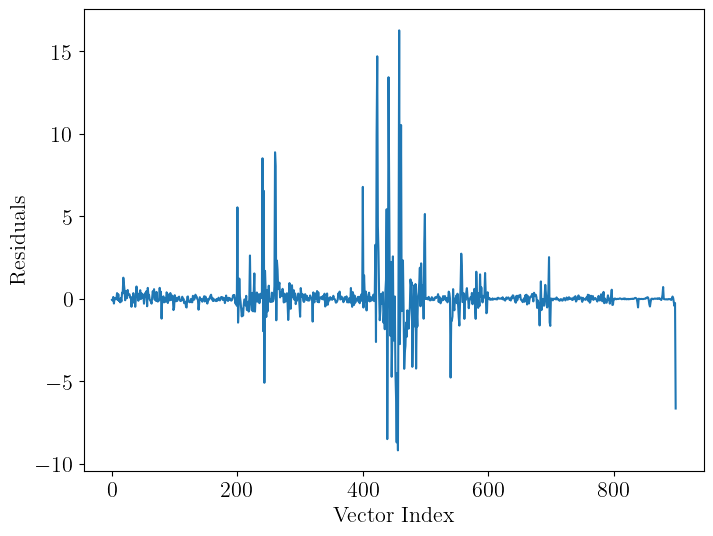

In [6]:
# compute the residuals, or the relative difference between the data and the model
resids = (noisy_data_set1[0] - model) / model

# plot the residuals
plt.figure(figsize=(8,6),dpi=100)
plt.plot(resids)
plt.xlabel('Vector Index')
plt.ylabel('Residuals')
plt.show()

We see from the above plot that the difference between the noisy data and the model oscillates around zero. Hence, the data scatters around the truth.

## Task 2: 
#### Use the provided covariance matrix and the model as a reference.
### 2.1: Test if set 1 follows a $\chi^2$ distribution with the correct degrees of freedom, by measuring its mean and variance. 
### 2.2: Convince yourself, that the measured $\chi^2$ follows a $\chi^2$ distribution.

In [7]:
inv_cov = inv(cov) # invert the covariance matrix
chi2 = [] # a list to hold the chi^2 values

# compute the chi^2 for all dv
for i in range(len(noisy_data_set1)):
    diff = model - noisy_data_set1[i]
    chi2.append(diff.T @ inv_cov @ diff)

The mean $\chi^2$ should be equal to the degrees of freedom. For a system where we don't fit the data, the degrees of freedom are equal to the dimension of the data vector. So, our mean $\chi^2$ should be $900$. The variance of the $\chi^2$ distribution should in general be the twice the mean, so ours should be $1800$. We'll compute below whether this is the case for our distribution.

In [8]:
# What are the mean and variance?
mean = np.mean(chi2) 
var = np.var(chi2) 
print('mean:\t\t{:.2f}'.format(mean)) # mean = dimension
print('variance:\t{:.2f}'.format(var)) # var = 2*dimension

mean:		899.65
variance:	1784.46


We see that the mean and variance are approximately equal to the expected values, with slight deviations that we would expect from random sampling. We'll now check if the overall distribution is right by histogramming our $\chi^2$ values and normalizing the result, then comparing it to a plot of the expected probability density function for a $\chi^2$ distribution with 900 degrees of freedom.

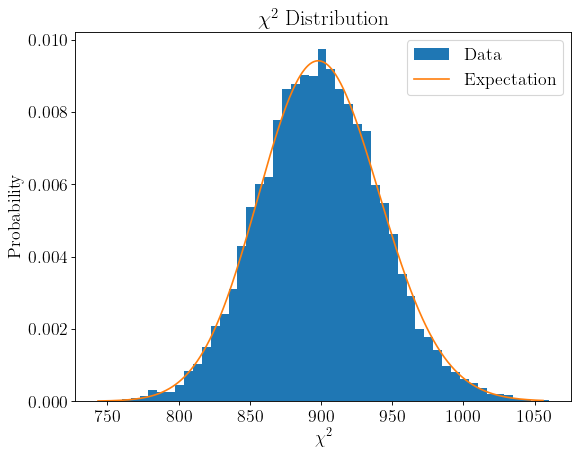

In [9]:
# is the overall distribution right?

spread = np.max(chi2) - np.min(chi2) # compute the range of chi^2 values (for plotting)
x = np.linspace(mean-spread/2,mean+spread/2,1000) # define a range of input values for plotting the pdf

plt.figure(figsize=(8,6),dpi=80)
plt.hist(chi2,50,density=True,label='Data') # histogram the chi^2 data and normalize
plt.plot(x,chi2_scp.pdf(x,900),label='Expectation') # plot the expected pdf for a chi^2 distribtion
plt.title('$\chi^2$ Distribution')
plt.xlabel('$\chi^2$')
plt.ylabel('Probability')
plt.legend()
plt.show()

We see that our histogram is consistent with the expected probability density function, so the overall $\chi^2$ distribution is correct.

### After convincing us that the two sets actually follow a $\chi^2$ distribution, if we use the analytical covariance matrix, we want to check if that is also true if we measure the covariance matrix from simulations. 
### As running simulations is too expensive, we simulate measurements from simulations with the created set 2. 
### Task 3: As a preparation, please measure the numerical covariance matrix from [500,1000,5000,10000] data vectors from set 2. What do you observe in the correlation matrix? Are the covariances positive semi-definite?

In [10]:
# generate numerical covariance matrices from the specified range of data vectors in set 2 using NumPy
cov_num500 = np.cov(noisy_data_set2[:500].T)
cov_num1000 = np.cov(noisy_data_set2[:1000].T)
cov_num5000 = np.cov(noisy_data_set2[:5000].T)
cov_num10000 = np.cov(noisy_data_set2[:10000].T)

A matrix is positive semi-definite if it is symmetric and has only non-negative eigenvalues. The covariance matrix is symmetric by definition, so we only have to check if it has any non-negative eigenvalues. We do so below.

In [11]:
# compute the eigenvalues of each covariance matrix using NumPy
eigs500 = eigvals(cov_num500)
eigs1000 = eigvals(cov_num1000)
eigs5000 = eigvals(cov_num5000)
eigs10000 = eigvals(cov_num10000)

# print whether each matrix has negative eigenvalues
print('The 500x500 covariance matrix has negative eigenvalues:\t\t',np.any(eigs500<0)) # should be True
print('The 1000x1000 covariance matrix has negative eigenvalues:\t',np.any(eigs1000<0)) # should be False
print('The 5000x5000 covariance matrix has negative eigenvalues:\t',np.any(eigs5000<0)) # should be False
print('The 10000x10000 covariance matrix has negative eigenvalues:\t',np.any(eigs10000<0)) # should be False

The 500x500 covariance matrix has negative eigenvalues:		 True
The 1000x1000 covariance matrix has negative eigenvalues:	 False
The 5000x5000 covariance matrix has negative eigenvalues:	 False
The 10000x10000 covariance matrix has negative eigenvalues:	 False


We see that the the covariance matrix generated from 500 data vectors has negative eigenvalues, and is thus *not* positive semi-definite. Those generated from 1000, 5000 and 10000 data vectors have no negative eigenvalues, and thus *are* positive semi-definite. This is the expected result since a covariance matrix is typically positive semi-definite if the number of realisations used to compute it is greater than the rank of the matrix. In this case, our dimension (or rank) is 900, so the matrix computed from fewer than 900 data vectors is the only one that is not positive semi-definite.

We'll now compute the correlation matrices and plot them as colour maps to examine their structure.

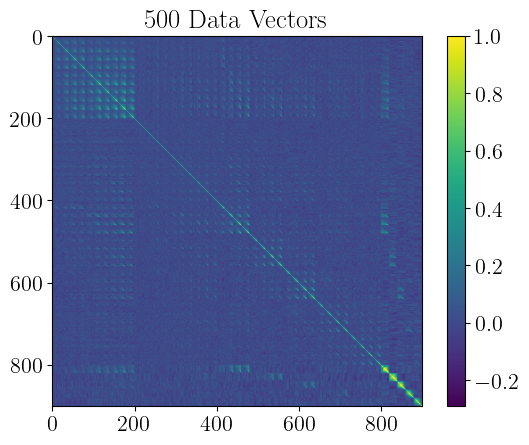

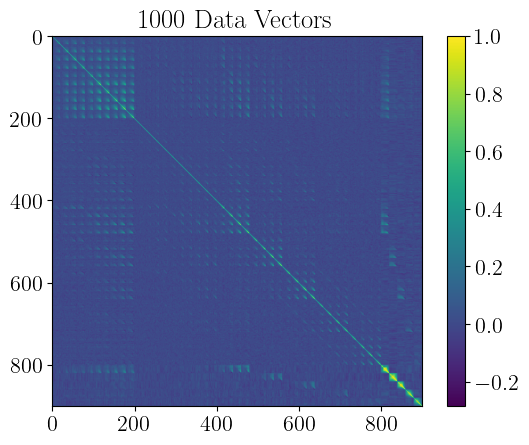

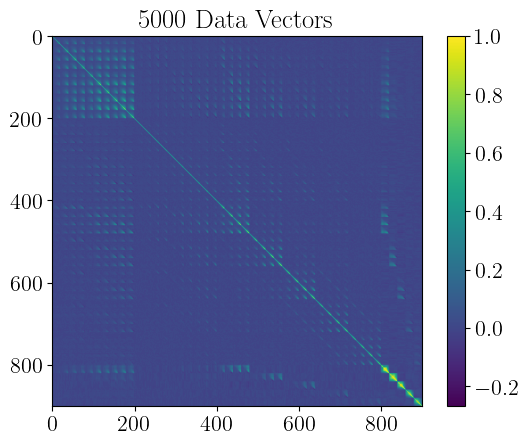

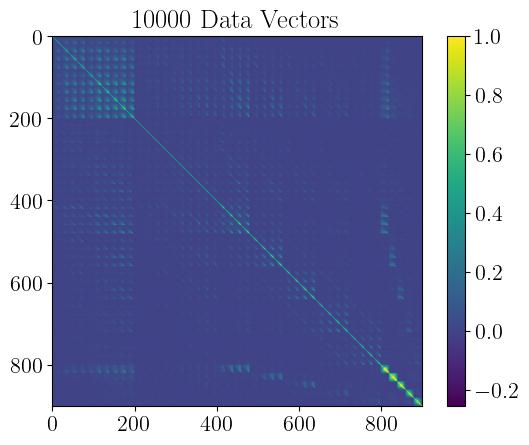

In [12]:
# compute the correlation matrices from the covariance matrices
corr500 = cov_num500/np.outer(np.sqrt(np.diag(cov_num500)),np.sqrt(np.diag(cov_num500)))
corr1000 = cov_num1000/np.outer(np.sqrt(np.diag(cov_num1000)),np.sqrt(np.diag(cov_num1000)))
corr5000 = cov_num5000/np.outer(np.sqrt(np.diag(cov_num5000)),np.sqrt(np.diag(cov_num5000)))
corr10000 = cov_num10000/np.outer(np.sqrt(np.diag(cov_num10000)),np.sqrt(np.diag(cov_num10000)))

# plot each of the correlation matrices using a colour scale
plt.figure(dpi=100)
plt.title('500 Data Vectors')
plt.imshow(corr500)
plt.colorbar()
plt.show()

plt.figure(dpi=100)
plt.title('1000 Data Vectors')
plt.imshow(corr1000)
plt.colorbar()
plt.show()

plt.figure(dpi=100)
plt.title('5000 Data Vectors')
plt.imshow(corr5000)
plt.colorbar()
plt.show()

plt.figure(dpi=100)
plt.title('10000 Data Vectors')
plt.imshow(corr10000)
plt.colorbar()
plt.show()

We notice from the above correlation matrices that the structure is very similar for each number of realisations, though the matrices generated from more data vectors are slightly smoother. As expected, the diagonal terms are all $1$ and the matricies are all symmetric. We also see clear structure in the off-diagonal terms, with higher correlations in 'squares' on the plot. On average, we see greater correlation for terms near the diagonal, though there is still some structure or noise in distant off-diagonal terms.

### Task 4: Test for all four covariance matrices if you recover a $\chi^2$ distribution with the mean and variance. What do you observe? 

We'll start by defining a function that computes and plots the $\chi^2$ distribution, and also prints the mean and variance, given a data set and a covariance matrix. This will make the code neater going forward since this process will repeated many times. We include a flag for the Hartlap factor here, though we don't use it until Task 5.

In [13]:
# compute and plot chi^2 distributions, and print the mean and variance
def plot_cov(set,cov,num,hartlap,title=None):
    # 'set' is the set of data vectors
    # 'cov' is the covariance matrix
    # 'num' is the number of realisations used to generate the covariance matrix
    # 'hartlap' is a boolean that specifies whether to correct with the Hartlap factor
    # 'title' is an optional parameter for the title of the plot

    # check whether to correct the inverse covariance matrix with the Hartlap factor
    if hartlap:
        # compute the inverse of the given covariance matrix and correct with the Hartlap factor
        n_r = int(num)
        n_d = len(cov)
        h = (n_r-1)/(n_r-n_d-2)
        inv_cov = inv(cov)/h
    else:
        # compute the inverse of the given covariance matrix
        inv_cov = inv(cov)
    
    # compute the chi^2 values for all dv
    chi2 = []
    for i in range(10000):
        diff = model - set[i]
        chi2.append(diff.T @ inv_cov @ diff)

    # compute and print the mean and variance
    mean = np.mean(chi2) 
    var = np.var(chi2)
    print('For the chi-squared distribution generated from {} data vectors:'.format(num))
    print('mean:\t\t{:.2f}'.format(mean)) # mean = dimension
    print('variance:\t{:.2f}'.format(var)) # var = 2*dimension

    # prepare to plot the expected probability density function
    spread = np.max(chi2) - np.min(chi2) # compute the range of chi^2 values for plotting
    x = np.linspace(mean-spread/2,mean+spread/2,1000) # define a range of input values for plotting the pdf

    # plot the computed chi^2 distribution and the expected distribution
    plt.figure(figsize=(8,6),dpi=80)
    plt.hist(chi2,50,density=True,label='Data') # histogram the chi^2 data and normalize
    plt.plot(x,chi2_scp.pdf(x,900),label='Expectation') # plot the expected pdf for a chi^2 distribtion
    if title:
        # give the plot the specified title, if applicable
        plt.title(title)
    else:
        # default plot title
        plt.title('{} Data Vectors'.format(num))
    plt.xlabel('$\chi^2$')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

    return

Since the covariance matrices were generated using data set 2, we'll test whether the matrices recover a $\chi^2$ distribution on set 1 to avoid biasing our results. We print the mean and variance, and we plot the $\chi^2$ distributions below for each of the four covariance matrices using the function defined above. Note that the flag for the Hartlap factor is `False` in this part.

For the chi-squared distribution generated from 500 data vectors:
mean:		-4578888448108537.00
variance:	132261233240461526039501444816568320.00


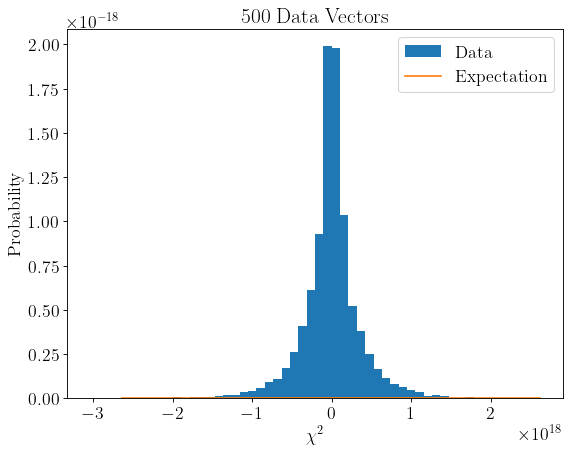

For the chi-squared distribution generated from 1000 data vectors:
mean:		9254.82
variance:	2043972.23


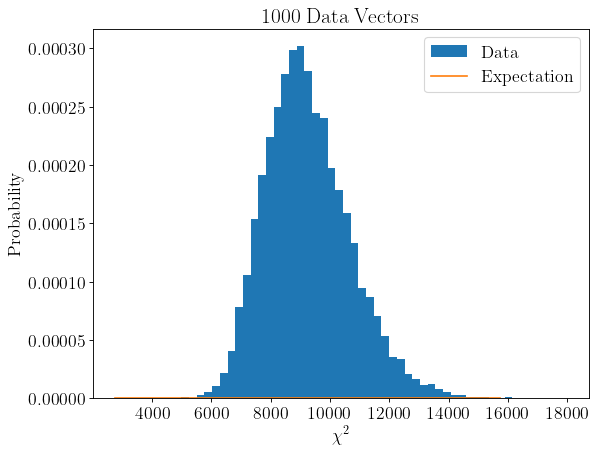

For the chi-squared distribution generated from 5000 data vectors:
mean:		1098.31
variance:	3233.82


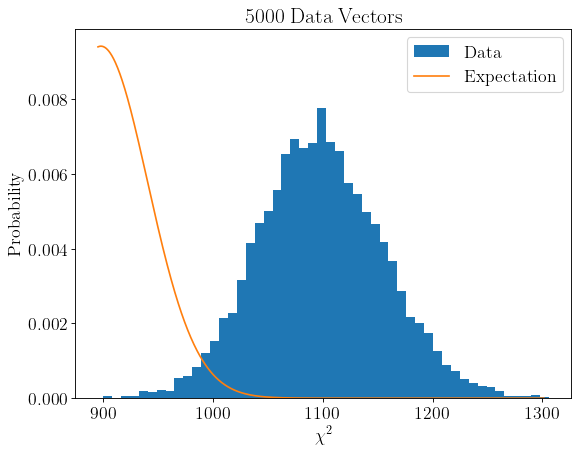

For the chi-squared distribution generated from 10000 data vectors:
mean:		988.48
variance:	2375.36


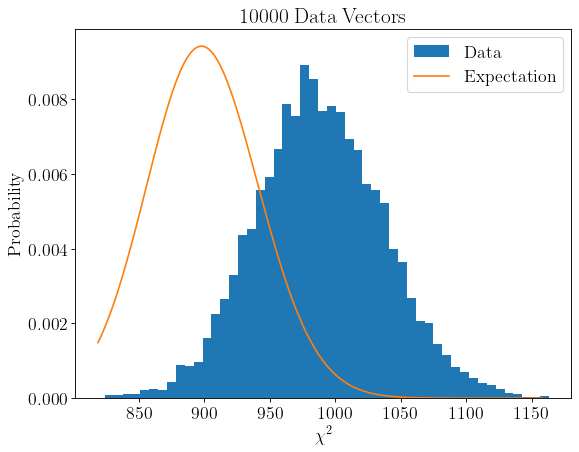

In [14]:
plot_cov(noisy_data_set1,cov_num500,500,False)
plot_cov(noisy_data_set1,cov_num1000,1000,False)
plot_cov(noisy_data_set1,cov_num5000,5000,False)
plot_cov(noisy_data_set1,cov_num10000,10000,False)

We notice that none of our $\chi^2$ distributions follow the expected probability density function, and none of the printed means and variances are approximately equal to $900$ and $1800$, respectively. So, none of the four covariance matrices recover a $\chi^2$ distribution with the expected mean and variance. However, we remark that the covariance matrices computed from a greater number of data vectors increasingly approach the correct distribuion, with the convergence seemingly slowing as we add data vectors.

### Task 5: Repeat the same exercise from before, but debias your inverse covriance matrix with the so-called Hartlap factor. What do you observe?

We repeat Task 4 by calling the same function that we defined previously, however we set our Hartlap flag to `True` in order to debias our inverse covariance matrix via the Hartlap factor. To see how this is implemented, refer to the function definition at the top of Task 4.

For the chi-squared distribution generated from 500 data vectors:
mean:		3688803920119502.50
variance:	85838789147800791584202706185617408.00


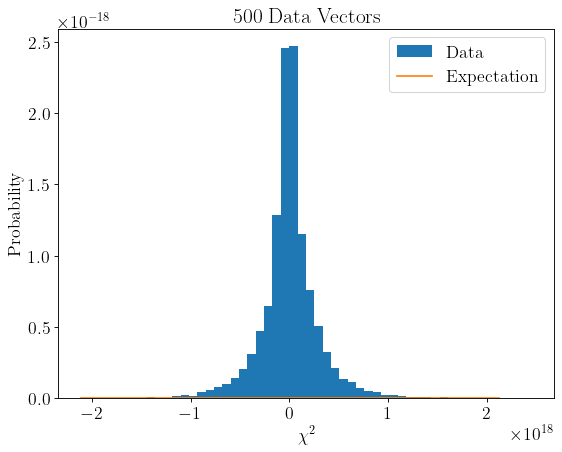

For the chi-squared distribution generated from 1000 data vectors:
mean:		907.88
variance:	19669.63


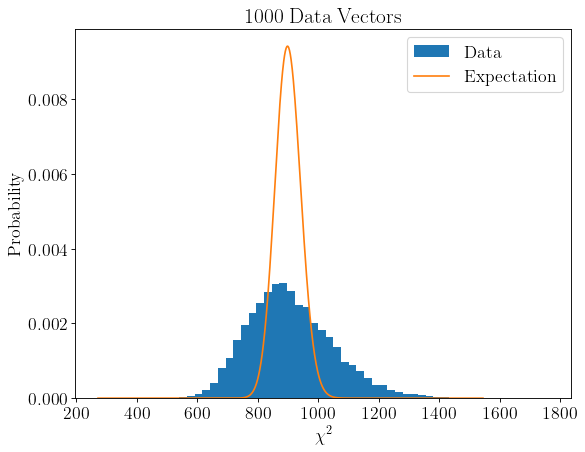

For the chi-squared distribution generated from 5000 data vectors:
mean:		900.35
variance:	2173.17


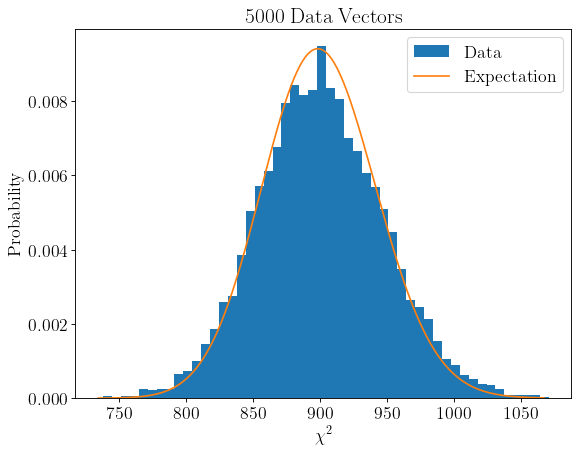

For the chi-squared distribution generated from 10000 data vectors:
mean:		899.41
variance:	1966.56


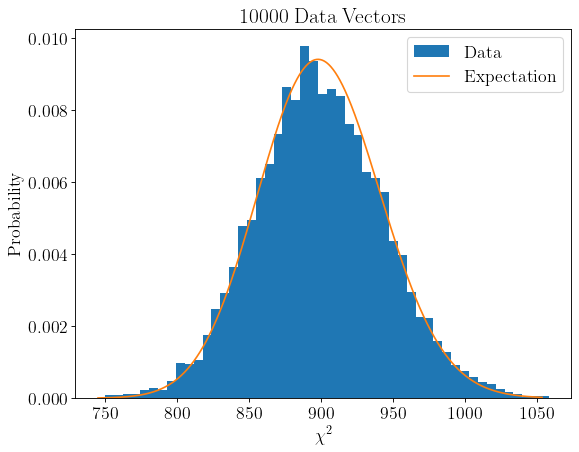

In [15]:
plot_cov(noisy_data_set1,cov_num500,500,True)
plot_cov(noisy_data_set1,cov_num1000,1000,True)
plot_cov(noisy_data_set1,cov_num5000,5000,True)
plot_cov(noisy_data_set1,cov_num10000,10000,True)

From the above plots, we observe that the coviance matrices generated from few data vectors relative to the dimension of the matrix still fail to produce the expected $\chi^2$ distribution. However, the matrices computed from many more realisations approach the correct distribution with the correct mean and variance. It seems that the Hartlap factor succeeded in debiasing the inverse covariance matrix.

We note that it's expected for the distribution generated from fewer than 900 data vectors to perform very poorly despite the Hartlap factor, as it doesn't meet the condition discussed in Task 3 of having more realisations than the rank of the covariance matrix. Once we have more than 900 realisations, we see immediately that our distribution's mean has been properly corrected by the Hartlap factor, but many more data vectors are required in order to reduce the variance to the expected value of twice the mean.

### Task 6: Repeat task 5 again, but this time, test if set 2 also follows a $\chi^2$ distribution. What do you observe?

We repeat Task 5 by calling the same function that we defined previously, however we specify that we're using set 2 rather than set 1.

For the chi-squared distribution generated from 500 data vectors:
mean:		3158577458894205.00
variance:	80158717571003645983220381415112704.00


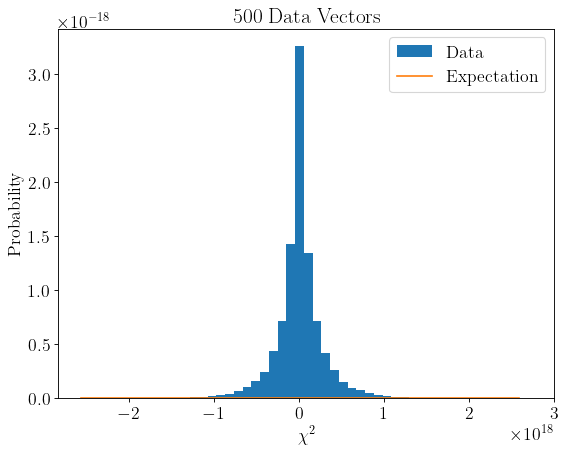

For the chi-squared distribution generated from 1000 data vectors:
mean:		826.43
variance:	78127.45


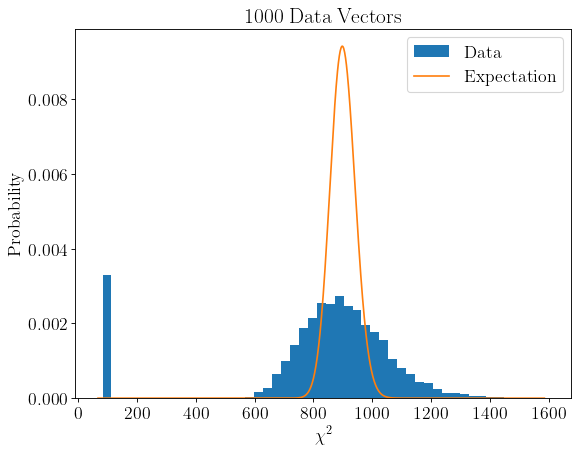

For the chi-squared distribution generated from 5000 data vectors:
mean:		819.55
variance:	8278.34


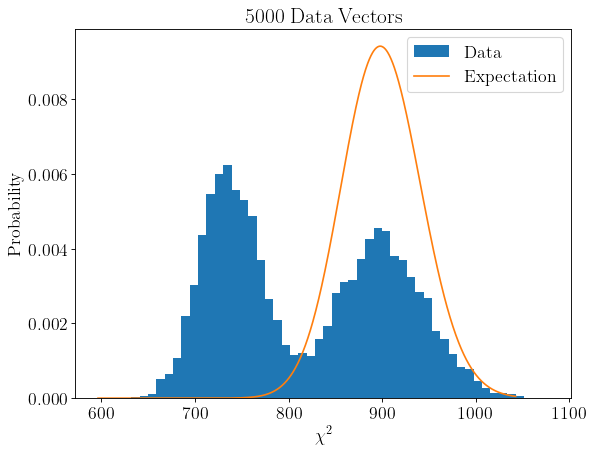

For the chi-squared distribution generated from 10000 data vectors:
mean:		818.91
variance:	1365.75


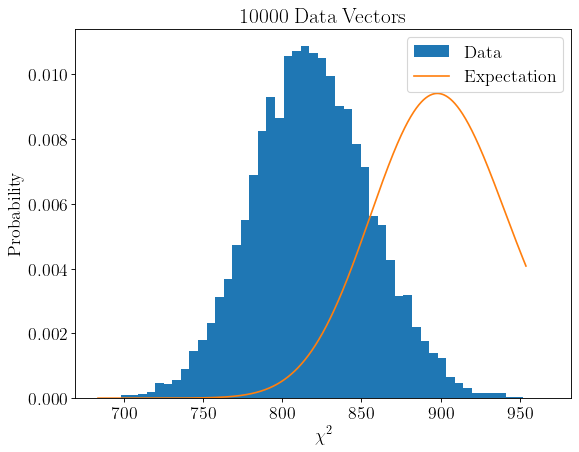

In [16]:
plot_cov(noisy_data_set2,cov_num500,500,True)
plot_cov(noisy_data_set2,cov_num1000,1000,True)
plot_cov(noisy_data_set2,cov_num5000,5000,True)
plot_cov(noisy_data_set2,cov_num10000,10000,True)

We observe that the covariance matrix generated from 500 data vectors produces a similarly poor $\chi^2$ distribution to in the previous 2 Tasks. The distribuion computed from 1000 vectors has an additional thin peak at a lower $\chi^2$, and that computed from 5000 vectors is clearly bimodal with one peak at the correct mean and another at lower $\chi^2$. Finally the distribuion computed from 10000 vectors has a single peak with a lower than expected mean.

The reason that we see distributions with lower mean $\chi^2$ than expected is because we tested our covariance matrices on the same data set from which we computed them. This lead to biased results for the data vectors used to produce the covariance matrix. The covariance for these sets is greater, leading to a smaller $\chi^2$ value. In the case of the 5000 used data sets, half of the vectors in set 2 were used to generate the covariance matrix. So, we get a biased peak at low mean $\chi^2$, and an unbiased peak from the unused vectors with the correct mean. Hence, we have a relatively balanced bimodal distribution. In the case of the 1000 used data sets, one tenth of the vectors in set 2 were used to generate the covariance matrix. So, we get a smaller biased peak at low mean $\chi^2$, and a larger unbiased peak from the unused vectors with the correct mean. In the case of the 10000 used data sets, all of the vectors in set 2 were used to generate the covariance matrix, so the entire distribution is shifted to lower $\chi^2$.

### Bonus Task 1: Create a new set of 10000 noisy data vectors using the numerical covariance matrix measured from 1000 noisy data vectors. Is it possible to reduce the noise in the covariance matrix with this method? Test if set 1 follows a $\chi^2$ distribution which the newly created covaraince matrix. What do you observe?

We start by generating a new set of 10000 noisy data vectors, as we did in Task 1, using the numerical covariance matrix computed from 1000 noisy data vectors in Task 3. We then compute the numerical covariance matrix from all data vectors in this new set.

In [17]:
# generate a new set of noisy data vectors using a numerical covariance matrix
noisy_data_set3 = np.random.multivariate_normal(model,cov_num1000,10000) 
cov_num10000_set3 = np.cov(noisy_data_set3.T) # compute the covariance using the above data vectors

Now that the covariance matrix has been computed, we'll compute and plot the associated correlation matrix and examine its structure.

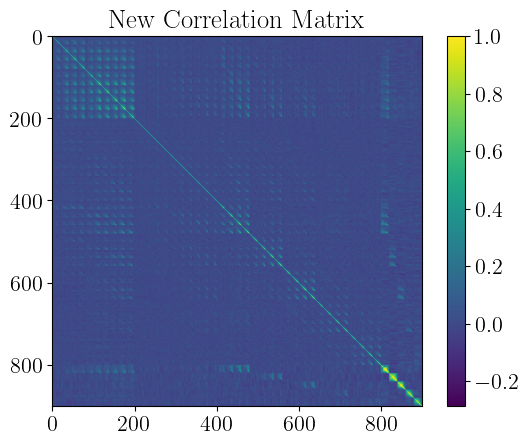

In [18]:
# compute the correlation from the new covariance matrix
corr10000_set3 = cov_num10000_set3/np.outer(np.sqrt(np.diag(cov_num10000_set3)),np.sqrt(np.diag(cov_num10000_set3)))

# plot the correlation matrices using a colour scale
plt.figure(dpi=100)
plt.title('New Correlation Matrix')
plt.imshow(corr10000_set3)
plt.colorbar()
plt.show()

We observe that the correlation matrix displays very similar structure to those generated from the covariance computed in Task 3. There's no qualitatively obvious increase or reduction in the noise or structure.

Now, we'll plot the $\chi^2$ distribution of set 1 with the new covariance matrix, using the function defined in Task 4. This will allow us to see if the new covariance matrix produces a distribution with the correct mean, variance and shape.

For the chi-squared distribution generated from 10000 data vectors:
mean:		9252.79
variance:	2074431.62


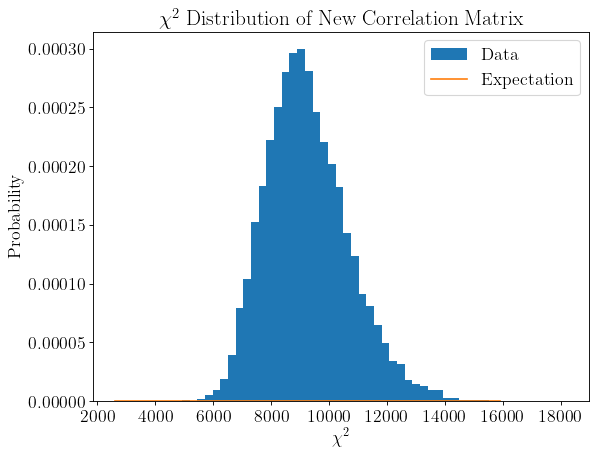

In [19]:
# plot the chi^2 distribution of set 1 with the new covariance
plot_cov(noisy_data_set1,cov_num10000_set3,10000,True,'$\chi^2$ Distribution of New Correlation Matrix')

We observe that set 1 with the newly created covariance matrix does not follow a $\chi^2$ distribution with the correct mean and variance. The mean $\chi^2$ is approximately 10 times the expected value of 900, and the variance is approximately 200 times the mean rather than twice the mean. This suggests that it is not possible to reduce the noise in the covariance matrix by recomputing it from the noisy data vectors produced from the original model and covariance matrix.

This is an intuitively reasonable result, as computing covariance from noisy data should not in principle reduce the noise in the result. The covariance of many data vectors produced from the original model should approach the true covariance matrix. However, the covariance of many data vectors produced from a noisy numerical covariance could, at best, only approach the noise of the numerical covariance matrix. So, the noise in the covariance matrix cannot be reduced using this method.

### Bonus task 2: What is the minimum number of data vectors such that the inverse covariance matrix is non-singular? What is an easy tool to test this? Is an analytical covariance matrix always invertible? What can you do if it is not invertible? 

A singular matrix is a square matrix that is not invertible, which implies that its determinant is zero (or vice versa). The minimum number of data vectors such that a covariance matrix is invertible, and thus non-singular, was given in lecture to be equal to the rank of the covariance matrix. Mathematically, $n \geq m$, where $m$ is the rank of the covariance matrix and $n$ is the number of data vectors (or realisations) used to compute the matrix. Since this is true for a covariance matrix, it must also be true for its inverse, as the inverse of a matrix's inverse is the matrix itself.

An easy tool to test whether a matrix is singular is to check whether it has any negative or complex eigenvalues. If all of the eigenvalues are real and non-negative, then the covariance matrix is non-singular. Otherwise, it is singular. We can use this principle to verify the claim that a covariance matrix is non-singular if $n \geq m$. We do so below by looping through covariance matrices generated from a range of numbers of data vectors and checking whether the matrix is singular.

In [20]:
# loop through a range of numbers of data vectors around 900
for i in range(890,911,1):
    # compute the covariance matrix from the specified number of data vectors
    cov = np.cov(noisy_data_set1[:i].T)
    eig = eigvals(cov) # compute the eigenvalues using NumPy
    # check if the matrix is singular (has negative or complex eigenvalues)
    if np.all((eig >= 0)) and np.all(np.isreal(eig)):
        print(i,'data vectors \t non-singular')
        #break
    else:
        print(i,'data vectors:\t singular')

890 data vectors:	 singular
891 data vectors:	 singular
892 data vectors:	 singular
893 data vectors:	 singular
894 data vectors:	 singular
895 data vectors:	 singular
896 data vectors:	 singular
897 data vectors:	 singular
898 data vectors:	 singular
899 data vectors:	 singular
900 data vectors 	 non-singular
901 data vectors 	 non-singular
902 data vectors 	 non-singular
903 data vectors 	 non-singular
904 data vectors 	 non-singular
905 data vectors 	 non-singular
906 data vectors 	 non-singular
907 data vectors 	 non-singular
908 data vectors 	 non-singular
909 data vectors 	 non-singular
910 data vectors 	 non-singular


We see from the above calculations that the covariance matrix is singular when computed with fewer than 900 data vectors, and non-singular when computed with greater than 900 data vectors, as expected. This can be checked for some other range of data vectors by modifying the above cell. We note that running the above code with different sets of noisy data sets sometimes gives a singular matrix for 900 data vectors, and sometimes gives a non-singlar matrix for 900 data vectors. We interpret this to be due to the random noise in the data set, since 900 realisations the right on the threshold of $n \geq m$. There are also much rarer instances of other numbers of realisations very near 900 which give unnexpected results, which we also attribute to noise.

Regarding the next parts of the question, analytic covariance matrices are not always invertible. This is implied in the lecture notes, where a listed advantage of numerical covariances over analytic ones is that they are always invertible if enough realisations are used. An analytic covariance matrix can be singular if there is linear dependance among the variables used, or if the chosen variables don't span the full solution space.

If a covariance matrix is not invertible, the problem can be solved via singular value decomposition. The process of singular value decomposition is detailed in the lecture notes, and will be summarized here. Singular value decomposition enables you to decompose a matrix into the product of three component matrices. The middle matrix in this product is diagonal. We remove all of the negative eigenvalues in the middle matrix, as well as the corresponging rows and columns in the other two matrices, which removes the corresponing eigenvectors. Finally, carrying out the matrix multilication re-constructs the covariance matrix without any negative eigenvalues. Thus, the covariance matrix is now non-singular.